<a href="https://colab.research.google.com/github/Ashikul-Naim2/Wav2Vec---harshit345/blob/main/Wav2Vec---harshit345(modifyed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import shutil
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Specify source and destination paths
DRIVE_PATH = "/content/drive/MyDrive/Anoted_Imotion_Dataset"  # make sure this exists in your Drive
LOCAL_PATH = "/content/Anoted_Imotion_Dataset"

# Step 3: Copy dataset to Colab local storage
shutil.rmtree(LOCAL_PATH, ignore_errors=True)
shutil.copytree(DRIVE_PATH, LOCAL_PATH)

print(f"Dataset copied to {LOCAL_PATH}")

Mounted at /content/drive
Dataset copied to /content/Anoted_Imotion_Dataset


Device: cuda


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at harshit345/xlsr-wav2vec-speech-emotion-recognition and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Labels: {'Angry': 0, 'Excited': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4}
Total audio files: 4997


Map:   0%|          | 0/4997 [00:00<?, ? examples/s]

Train size: 3997 Eval size: 1000
Precomputing train features ...
Precomputing test features ...


Step,Training Loss
50,1.323800
100,1.044000
150,0.882000
200,0.867300
250,0.796200
300,0.667400
350,0.613100
400,0.643600
450,0.572000
500,0.627200


Evaluation metrics: {'eval_loss': 0.4235827624797821, 'eval_accuracy': 0.891, 'eval_f1': 0.891164382533728, 'eval_runtime': 54.6405, 'eval_samples_per_second': 18.301, 'eval_steps_per_second': 9.151, 'epoch': 3.0}

Classification Report:
              precision    recall  f1-score   support

       Angry       0.90      0.88      0.89       191
     Excited       0.84      0.86      0.85       209
       Happy       0.83      0.84      0.84       205
     Neutral       0.95      0.98      0.96       185
         Sad       0.95      0.90      0.92       210

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



<Figure size 1000x800 with 0 Axes>

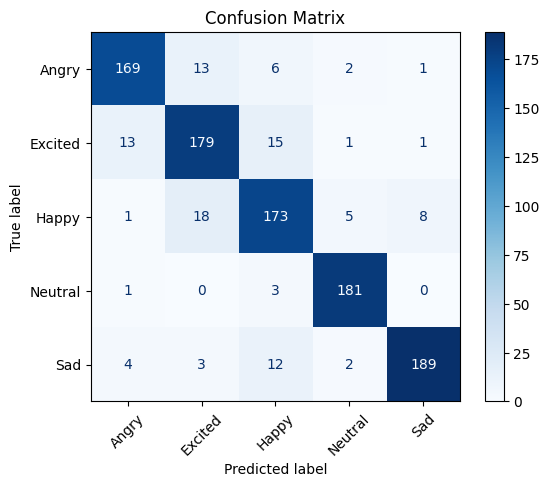

Saved model & feature extractor to ./wav2vec2-ser-model


In [ ]:
# ---------------------------
# Wav2Vec2 Speech Emotion Recognition (memory-optimized)
# Compatible with Transformers 4.57.3
# ---------------------------

# Install packages (if not installed)
!pip install -q "transformers==4.57.3" "datasets" "torchaudio" librosa soundfile evaluate scikit-learn matplotlib

# Imports
import os
import librosa
import numpy as np
import torch
import logging
from datasets import Dataset, DatasetDict
import evaluate
from transformers import (
    AutoConfig,
    AutoFeatureExtractor,
    AutoModelForAudioClassification,
    TrainingArguments,
    Trainer,
    set_seed,
)
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ---------- CONFIG ----------
DATASET_PATH = "/content/drive/MyDrive/Anoted_Imotion_Dataset"
MODEL_NAME = "harshit345/xlsr-wav2vec-speech-emotion-recognition"
OUTPUT_DIR = "./wav2vec2-ser-model"
SAMPLE_RATE = 16000
SEED = 42

BATCH_SIZE = 2  # smaller batch to avoid OOM
GRAD_ACCUM_STEPS = 4  # effective batch size = BATCH_SIZE * GRAD_ACCUM_STEPS
EPOCHS = 3
LEARNING_RATE = 5e-5
MAX_AUDIO_LENGTH = 160000  # maximum audio length (in samples) to prevent huge tensors
MAX_TRAIN_SAMPLES = None
MAX_EVAL_SAMPLES = None
# ----------------------------

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load model + feature extractor
config = AutoConfig.from_pretrained(MODEL_NAME)
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
model = AutoModelForAudioClassification.from_pretrained(MODEL_NAME, config=config).to(device)

# Build label mapping from your folders
label_dirs = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
if not label_dirs:
    raise RuntimeError(f"No label folders found in {DATASET_PATH}")
label2id = {lab: idx for idx, lab in enumerate(label_dirs)}
id2label = {idx: lab for lab, idx in label2id.items()}
print("Labels:", label2id)

# Collect file paths + labels
paths = []
labels = []
for lab in label_dirs:
    folder = os.path.join(DATASET_PATH, lab)
    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith((".wav", ".mp3", ".flac", ".ogg"))])
    for f in files:
        paths.append(f)
        labels.append(label2id[lab])

print("Total audio files:", len(paths))

# Create HF Dataset
ds = Dataset.from_dict({"path": paths, "label": labels})

# Map: load audio as numpy array
def load_audio(example):
    speech, sr = librosa.load(example["path"], sr=SAMPLE_RATE, mono=True)
    example["array"] = speech.astype(np.float32)
    example["sampling_rate"] = SAMPLE_RATE
    return example

ds = ds.map(load_audio)

# Train/test split
ds_split = ds.train_test_split(test_size=0.2, seed=SEED)
dataset = DatasetDict({"train": ds_split["train"], "test": ds_split["test"]})

if MAX_TRAIN_SAMPLES:
    dataset["train"] = dataset["train"].select(range(MAX_TRAIN_SAMPLES))
if MAX_EVAL_SAMPLES:
    dataset["test"] = dataset["test"].select(range(MAX_EVAL_SAMPLES))

print("Train size:", len(dataset["train"]), "Eval size:", len(dataset["test"]))

# Precompute features to speed up training
precomp_dir = "./precomputed_wav2vec_feats"
os.makedirs(precomp_dir, exist_ok=True)

def precompute_and_save(split_name, ds_split):
    X = []
    y = []
    for ex in ds_split:
        arr = ex["array"]
        feats = feature_extractor(arr, sampling_rate=ex["sampling_rate"], return_tensors=None)
        X.append(np.array(feats["input_values"][0], dtype=np.float32))
        y.append(int(ex["label"]))
    # save as object array to allow variable lengths
    np.savez(os.path.join(precomp_dir, f"{split_name}_feats.npz"), X=np.array(X, dtype=object), y=np.array(y, dtype=np.int64), allow_pickle=True)
    return X, y

print("Precomputing train features ...")
train_X, train_y = precompute_and_save("train", dataset["train"])
print("Precomputing test features ...")
test_X, test_y = precompute_and_save("test", dataset["test"])

# Create HF Datasets
ds_train = Dataset.from_dict({"input_values": train_X, "label": train_y})
ds_test = Dataset.from_dict({"input_values": test_X, "label": test_y})
dataset = DatasetDict({"train": ds_train, "test": ds_test})

# Data collator with dynamic padding
def data_collator(batch):
    max_len = min(max(len(b["input_values"]) for b in batch), MAX_AUDIO_LENGTH)
    padded = np.zeros((len(batch), max_len), dtype=np.float32)
    for i, b in enumerate(batch):
        arr = b["input_values"]
        padded[i, :min(len(arr), max_len)] = arr[:max_len]
    labels = [b["label"] for b in batch]
    return {"input_values": torch.tensor(padded, dtype=torch.float32), "labels": torch.tensor(labels, dtype=torch.long)}

# Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=1)
    labels = eval_pred.label_ids
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1": f1}

# TrainingArguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    save_steps=500,
    report_to="none",
    remove_unused_columns=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Clear GPU cache
torch.cuda.empty_cache()

# Train
trainer.train()

# Evaluate
eval_metrics = trainer.evaluate(dataset["test"])
print("Evaluation metrics:", eval_metrics)

# Confusion matrix & classification report
preds_output = trainer.predict(dataset["test"])
logits = preds_output.predictions
if isinstance(logits, tuple):
    logits = logits[0]
y_pred = np.argmax(logits, axis=1)
y_true = np.array(dataset["test"]["label"])

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_dirs))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_dirs)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Save model + feature extractor
trainer.save_model(OUTPUT_DIR)
feature_extractor.save_pretrained(OUTPUT_DIR)
print("Saved model & feature extractor to", OUTPUT_DIR)
